# Descriptive statistics

In [1]:
%%capture
!pip install tabulate
!pip install pysentiment2
!pip install linearmodels

import pandas as pd
pd.options.mode.chained_assignment = None 
import pysentiment2 as ps
from google.colab import drive 
from tabulate import tabulate
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as md
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
import statsmodels.api as sm

pd.set_option('display.expand_frame_repr', False)
drive.mount("/content/gdrive")

The following code shows the raw dataset used in the sentiment analysis after excluding multiple stock ticker symbols related to one news articles, removing duplicates and companies without PERMNO match.

In [2]:
def count_words(Text):
    word_count = len(re.findall(r'\w+', Text))
    return word_count

data = pd.read_csv("gdrive/My Drive/Thesis/processed data/processdata_woSWandPS.csv")

#Prepare data for descriptive statistics
data["Date"] = pd.to_datetime(data["Date"], format = "%Y-%m-%d")
data["Word Count"] = [count_words(x) for x in data.Text]


#Function to split initial dataframe into dataframes grouped by year
def split_years(dt):
    dt["Year"] = dt["Date"].dt.year
    return [dt[dt["Year"] == y] for y in dt["Year"].unique()]

data_splt_years = split_years(data)
data_fill = []

for df_year_splt in data_splt_years:
    year = df_year_splt["Date"].iloc[0].year
    obs_count = len(df_year_splt)
    mean_word_count = round(df_year_splt["Word Count"].mean(),0)
    company_count = df_year_splt["Ticker"].nunique()

    data_fill.append([year, obs_count, mean_word_count, company_count])

#Calculate the metrics for the whole dataset
obs_count = len(data)
mean_word_count = round(data["Word Count"].mean(),0)
company_count = data["Ticker"].nunique()

data_fill.append(["All years", obs_count, mean_word_count, company_count])

df_by_year = pd.DataFrame(data_fill ,columns = ["Year", "News Articles", "Mean Word Count", "Company Count"])

print(tabulate(df_by_year, headers = "keys", tablefmt = "psql"))

+----+-----------+-----------------+-------------------+-----------------+
|    | Year      |   News Articles |   Mean Word Count |   Company Count |
|----+-----------+-----------------+-------------------+-----------------|
|  0 | 2009      |             111 |               849 |              70 |
|  1 | 2010      |            2790 |               433 |             865 |
|  2 | 2011      |            4277 |               460 |            1001 |
|  3 | 2012      |           10260 |               335 |            2279 |
|  4 | 2013      |           13143 |               275 |            3076 |
|  5 | 2014      |           26232 |               293 |            3997 |
|  6 | 2015      |           35457 |               344 |            4312 |
|  7 | 2016      |           36569 |               384 |            4261 |
|  8 | 2017      |           39629 |               479 |            4188 |
|  9 | 2018      |           77086 |               670 |            5195 |
| 10 | 2019      |       

Here we extract the top 120 stock ticker symbols with regards to news article frequency within the years 2015 until 2019. Within those we exclude these who do not match the data requirements or simply are no companies (e.g. SPX)

In [3]:
#Get top 120 companies with regards to news frequency (later only top 100, since some will be removed like SPX)

yearst = [2015, 2016, 2017, 2018, 2019]

data = data[data.Year.isin(yearst) == True]
unique_data_company =  data.groupby("Ticker").nunique()

unique_data_company.sort_values(by = "Text", ascending = False, inplace = True)

print(list(unique_data_company.index[0:120]))

['AAPL', 'AMZN', 'TSLA', 'FB', 'BA', 'NFLX', 'DIS', 'EFX', 'SPX', 'BAC', 'INTC', 'DAX', 'F', 'GLD', 'GE', 'GM', 'MSFT', 'SBUX', 'AIR', 'AAL', 'IBM', 'JPM', 'CMG', 'WFC', 'C', 'TWTR', 'WMT', 'MCD', 'AMD', 'NVDA', 'JNJ', 'GS', 'BABA', 'CAT', 'MU', 'CSCO', 'XOM', 'CVX', 'BP', 'GOOGL', 'USD', 'GPRO', 'COST', 'QQQ', 'HD', 'SQ', 'NKE', 'KO', 'TGT', 'AXP', 'ATVI', 'CMCSA', 'SNAP', 'DAL', 'LMT', 'T', 'ABBV', 'PFE', 'ADBE', 'GILD', 'CRM', 'VZ', 'AVGO', 'BX', 'LULU', 'BLK', 'FIT', 'KMI', 'BBY', 'UNH', 'AGI', 'AA', 'PG', 'AMAT', 'M', 'MRK', 'BIDU', 'QCOM', 'JCP', 'FDX', 'AMGN', 'BMY', 'ORCL', 'PYPL', 'BHP', 'MA', 'FRA', 'KR', 'SHOP', 'MO', 'PM', 'GME', 'CHK', 'VRX', 'ABX', 'MMM', 'COP', 'BBBY', 'UTX', 'IRBT', 'MS', 'SPY', 'FCX', 'HAL', 'AGN', 'UAL', 'HPQ', 'JWN', 'CVS', 'CELG', 'EA', 'STZ', 'V', 'APC', 'AZN', 'EBAY', 'ACN', 'ADP', 'GLW', 'PEP']


In [4]:
#Descriptive statistics of final dataset 

data_final = pd.read_csv("gdrive/My Drive/Thesis/processed data/data_whole_woS.csv")

data_final_ot = data_final[data_final.word_count != 0]
data_final_ot["Date"] = pd.to_datetime(data_final_ot["Date"], format = "%Y-%m-%d")
data_final_ot["Word Count"] = [count_words(x) for x in data_final_ot.Text]

data_splt_years = split_years(data_final_ot)
data_fill = []

for df_year_splt in data_splt_years:
    year = df_year_splt["Date"].iloc[0].year
    obs_count = len(df_year_splt)
    mean_word_count = round(df_year_splt["Word Count"].mean(),0)
    company_count = df_year_splt["Ticker"].nunique()

    data_fill.append([year, obs_count, mean_word_count, company_count])

#Calculate the metrics for the whole dataset
obs_count = len(data_final_ot)
mean_word_count = round(data_final_ot["Word Count"].mean(),0)
company_count = data_final_ot["Ticker"].nunique()

data_fill.append(["All years", obs_count, mean_word_count, company_count])

df_by_year = pd.DataFrame(data_fill ,columns = ["Year", "News Articles", "Mean Word Count", "Company Count"])

print(tabulate(df_by_year, headers = "keys", tablefmt = "psql"))


+----+-----------+-----------------+-------------------+-----------------+
|    | Year      |   News Articles |   Mean Word Count |   Company Count |
|----+-----------+-----------------+-------------------+-----------------|
|  0 | 2015      |            4341 |               833 |             100 |
|  1 | 2016      |            5383 |               841 |             100 |
|  2 | 2017      |            5716 |               926 |             100 |
|  3 | 2018      |            8523 |              1344 |             100 |
|  4 | 2019      |            6401 |              1407 |             100 |
|  5 | All years |           30364 |              1117 |             100 |
+----+-----------+-----------------+-------------------+-----------------+


Following code displays a descriptive table of the dictionary measures (soon adding ML measures)

In [5]:
data_dm = pd.read_csv("gdrive/My Drive/Thesis/processed data/data_whole_woS_dm.csv")
data_dm["Date"] = pd.to_datetime(data_dm["Date"], format = "%Y-%m-%d")

data_dm = data_dm.fillna(0)
data_dm["Size"] = np.log(data_dm["Size"])
data_dm_des = data_dm.loc[:, ~data_dm.columns.isin(["word_count", "HIV4_pos", "HIV4_neg", "LM_pos", "LM_neg"])]

print(data_dm_des.describe())

              Nasdaq       Turnover           Size            BTM     pref_alpha            CAR      HIV4_tone        LM_tone
count  130400.000000  130400.000000  130400.000000  130400.000000  130400.000000  130400.000000  130400.000000  130400.000000
mean        0.460000       1.869868      17.875239       0.525596       0.000037       0.000224       0.087899      -0.011694
std         0.498399       2.017987       1.423206       1.541150       0.001206       0.024104       0.190329       0.221183
min         0.000000       0.229915      12.701633      -1.291326      -0.008111      -0.417260      -1.000000      -1.000000
25%         0.000000       0.755302      17.148760       0.120729      -0.000572      -0.009528       0.000000       0.000000
50%         0.000000       1.165648      18.160598       0.256235       0.000090       0.000055       0.000000       0.000000
75%         1.000000       2.032845      18.920855       0.499991       0.000666       0.009791       0.000000       0

The plots below display the tone of the DM methods (HIV4 & LM) within 2015 for AAPL, AMZN, TSLA and BA. 

Attention: 0's from missing texts are removed

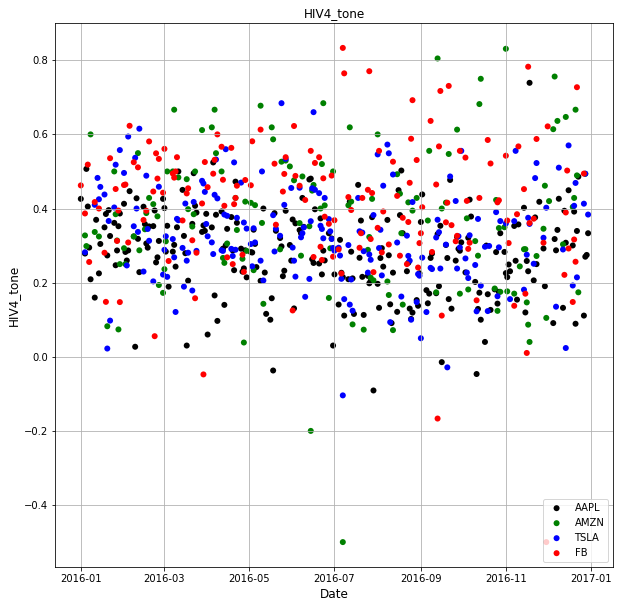

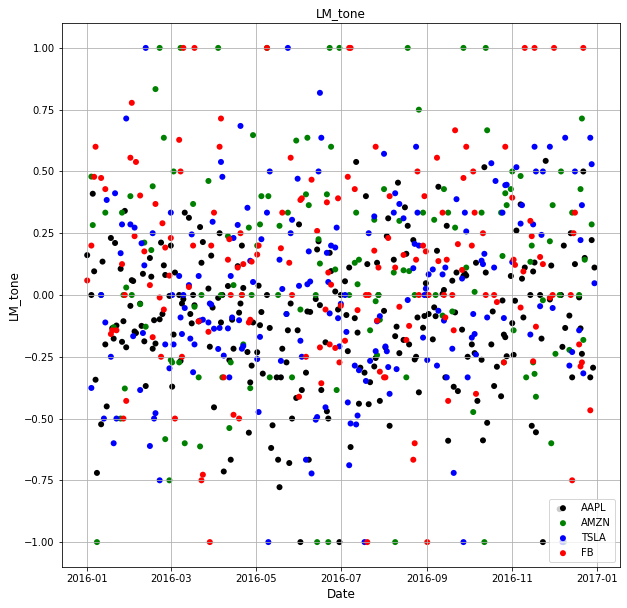

In [20]:
data_dm_4 = data_dm.loc[data_dm["Ticker"].isin(["AAPL", "AMZN", "TSLA", "FB"])]
data_dm_4 = data_dm_4[data_dm_4["HIV4_tone"] != 0]
data_dm_4["Date"] = pd.to_datetime(data_dm_4["Date"], format = "%Y-%m-%d")

data_dm_4 = data_dm_4[data_dm_4["Date"].dt.year == 2016]

fig1, ax1 = plt.subplots(figsize = (10, 10))

colors = {"AAPL":"black", "AMZN":"green", "TSLA":"blue", "FB":"red"}

tickers = ["AAPL", "AMZN", "TSLA", "FB"]


for tick in tickers:
    ax1.scatter(data_dm_4.loc[data_dm_4["Ticker"] == tick]["Date"], data_dm_4.loc[data_dm_4["Ticker"] == tick]["HIV4_tone"], c = colors[tick], edgecolors = "none", label = tick)

plt.grid()
plt.title("HIV4_tone")
plt.xlabel("Date", size=12)
plt.ylabel("HIV4_tone", size=12)
plt.legend(loc = 4)

fig2, ax2 = plt.subplots(figsize = (10, 10))

for tick in tickers:
    ax2.scatter(data_dm_4.loc[data_dm_4["Ticker"] == tick]["Date"], data_dm_4.loc[data_dm_4["Ticker"] == tick]["LM_tone"], c = colors[tick], edgecolors = "none", label = tick)

plt.grid()
plt.title("LM_tone")
plt.xlabel("Date", size=12)
plt.ylabel("LM_tone", size=12)
plt.legend(loc = 4)


The following graph displays several sentiment measures (DM + RF) of AAPL for 2015

130400


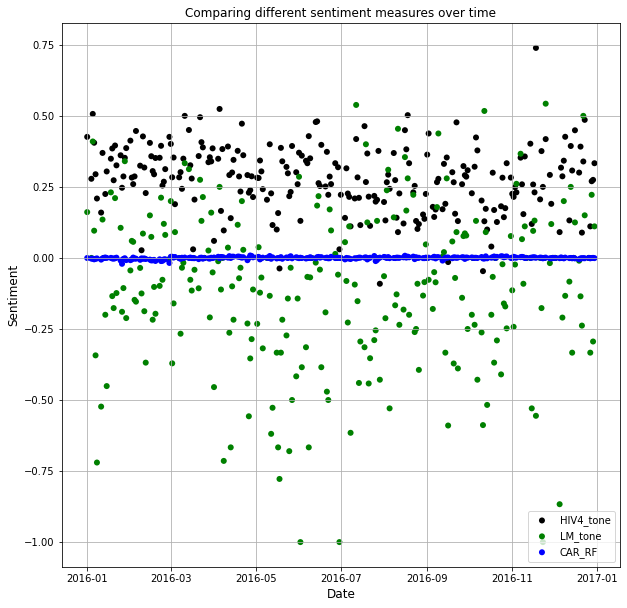

In [22]:
data_rf = pd.read_csv("gdrive/My Drive/Thesis/processed data/data_whole_woS_RF.csv")
data_rf["Date"] = pd.to_datetime(data_rf["Date"])

data_rf["Year"] = [x.year for x in data_rf["Date"]]
data_rf["Month"] = [x.month for x in data_rf["Date"]]
data_rf["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_rf.iterrows()]

data_lstm = pd.read_csv("gdrive/My Drive/Thesis/processed data/data_whole_woS_LSTM.csv")
data_lstm["Date"] = pd.to_datetime(data_lstm["Date"])

data_lstm["Year"] = [x.year for x in data_lstm["Date"]]
data_lstm["Month"] = [x.month for x in data_lstm["Date"]]
data_lstm["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data_lstm.iterrows()]

data_full = data_dm_des.merge(data_rf, how= "left", left_on = ["Date", "Ticker"], right_on = ["Date", "Ticker"])
data_full = data_full.drop(["Nasdaq_y", "Turnover_y", "Size_y", "BTM_y", "pref_alpha_y", "CAR_y",  "Text_y"], axis = 1)
data_full = data_full.rename(columns={"Nasdaq_x": "Nasdaq", "Turnover_x": "Turnover", "Size_x": "Size", "BTM_x": "BTM", "pref_alpha_x": "pref_alpha", "Text_x": "Text", "CAR_x": "CAR"})

data_full_1 = data_full.loc[data_full["Ticker"] == "AAPL"]
data_full_1 = data_full_1[data_full_1["Date"].dt.year == 2016]

sentiment_measures = ["HIV4_tone", "LM_tone", "CAR_RF"]
colors = {"HIV4_tone":"black", "LM_tone":"green", "CAR_RF":"blue"}

fig, ax = plt.subplots(figsize = (10, 10))

for sentiment in sentiment_measures:
  ax.scatter(data_full_1["Date"], data_full_1[sentiment], c = colors[sentiment], edgecolors = "none", label = sentiment)

plt.grid()
plt.title("Comparing different sentiment measures over time")
plt.xlabel("Date", size=12)
plt.ylabel("Sentiment", size=12)
plt.legend(loc = 4)



Here are the results of the panel data regression:

In [25]:
data = pd.read_csv("gdrive/My Drive/Thesis/processed data/data_whole_woS_dm.csv", index_col = False)

#Fill tone measures with 0 if NaN due to dividing by 0 word count
data = data.fillna(0)

data["Date"] = pd.to_datetime(data["Date"])
data["Year"] = [x.year for x in data["Date"]]
data["Month"] = [x.month for x in data["Date"]]
data["ordered_month"] = [((x[1]["Year"]-2015)*12 + x[1]["Month"]) for x in data.iterrows()]

data = data[~data.ordered_month.isin([0, 1, 2, 3])]

data["Size"] = np.log(data["Size"])

#HIV dictionary 

endg_var = "CAR"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "HIV4_tone"]

pooled_y = data[endg_var]
pooled_x = data[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_hiv4 = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_hiv4 = pooled_olsr_model_hiv4.fit()

print(pooled_olsr_model_results_hiv4.summary())

#LM dictionary

endg_var = "CAR"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "LM_tone"]

pooled_y = data[endg_var]
pooled_x = data[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_lm = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_lm = pooled_olsr_model_lm.fit()

print(pooled_olsr_model_results_lm.summary())

#RF sentiment

data_rf["Size"] = np.log(data_rf["Size"])

data_rf = data_rf[~data_rf.ordered_month.isin([0, 1, 2, 3])]

endg_var = "CAR"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "CAR_RF"]

pooled_y = data_rf[endg_var]
pooled_x = data_rf[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_rf = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_rf = pooled_olsr_model_rf.fit()

print(pooled_olsr_model_results_rf.summary())

#LSTM sentiment

data_lstm["Size"] = np.log(data_lstm["Size"])

data_lstm = data_lstm[~data_lstm.ordered_month.isin([0, 1, 2, 3])]

endg_var = "CAR"
exog_var = ["Nasdaq","Turnover","Size","BTM","pref_alpha", "CAR_LSTM"]

pooled_y = data_lstm[endg_var]
pooled_x = data_lstm[exog_var]

pooled_x = sm.add_constant(pooled_x)

pooled_olsr_model_lstm = sm.OLS(endog=pooled_y, exog=pooled_x)
pooled_olsr_model_results_lstm = pooled_olsr_model_lstm.fit()

print(pooled_olsr_model_results_lstm.summary())

print("Rsquared of HIV4: {} Rsquared of LM: {} Rsquared of RF: {} Rsquared of LSTM {}".format(pooled_olsr_model_results_hiv4.rsquared, pooled_olsr_model_results_lm.rsquared, pooled_olsr_model_results_rf.rsquared, pooled_olsr_model_results_lstm.rsquared))



                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.977
Date:                Mon, 23 May 2022   Prob (F-statistic):           1.96e-07
Time:                        09:32:39   Log-Likelihood:             2.8569e+05
No. Observations:              124000   AIC:                        -5.714e+05
Df Residuals:                  123993   BIC:                        -5.713e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -1.076      0.2